In [1]:
# from unityagents import UnityEnvironment
from collections import deque

import numpy as np
import progressbar as pb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

from environments import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make('G1Dist-v0')

Creating window glfw


In [4]:
# reset the environment
env_info = env.reset()

# size of each action
action_size = env.action_space.shape[0]
print('Size of each action:', action_size)

state_size = env.observation_space.shape[0]
print('Observation size: {}'.format(state_size))
print('The state for the agent looks like:', env_info)

Size of each action: 12
Observation size: 119
The state for the agent looks like: [ 0.29712628  0.99558591  0.0241443   0.06506156 -0.06318817  0.08023442
  0.08388292  0.02243796 -0.06586856 -0.07108037  0.09403731 -0.08561459
  0.03004344  0.072448    0.02088385  0.07405602  0.06706293  0.03753986
  0.1176581  -0.10550503  0.04827628 -0.11043132  0.0541397   0.2083382
  0.05289448 -0.06626858  0.12067946 -0.07989779  0.16216105  0.04877671
 -0.13722093 -0.0656478   0.09229514  0.03829873 -0.02390835  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -1.
 -1.          1.          1.         -1.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
 -1.         -1.          1.      

In [5]:
NUM_AGENTS = 1

def interact(action):
    action = action.reshape(NUM_AGENTS, action_size)
    next_state, reward, done, info = env.step(action)
    # next_state, reward, done = env_info.vector_observations, env_info.rewards, env_info.local_done
    return next_state.reshape(NUM_AGENTS, -1), np.array(reward).reshape(NUM_AGENTS, -1), np.array(done).reshape(NUM_AGENTS, -1)

def reset():
    state = env.reset().reshape(NUM_AGENTS, -1)
    return state

In [6]:
NET_SIZE = 512

class Policy(nn.Module):
    
    def __init__(self, state_size, action_size=1, n_agents=NUM_AGENTS, fc1_size=NET_SIZE, fc2_size=NET_SIZE):
        super(Policy, self).__init__()
        
        self.bn0 = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.bn1 = nn.BatchNorm1d(fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.bn2 = nn.BatchNorm1d(fc1_size)
        self.fc3_mu = nn.Linear(fc2_size, action_size)
        self.fc3_std = nn.Linear(fc2_size, action_size)

    def forward(self, state, log_std_min=-20, log_std_max=2):
        x = self.bn0(state)
        x = torch.relu(self.bn1(self.fc1(state)))
        x = torch.relu(self.bn2(self.fc2(x)))

        mean = self.fc3_mu(x)
        std = self.fc3_std(x)
        std = torch.clamp(std, log_std_min, log_std_max).exp()

        return mean, std
    
class Value(nn.Module):
    
    def __init__(self, state_size, action_size=1, n_agents=NUM_AGENTS, fc1_size=NET_SIZE, fc2_size=NET_SIZE):
        
        super(Value, self).__init__()
        
        self.bn0 = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, 1)
        
    def forward(self, x):
        x = self.bn0(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    
class Q(nn.Module):
    
    def __init__(self, state_size, action_size, n_agents=NUM_AGENTS, fc1_size=NET_SIZE, fc2_size=NET_SIZE):
        
        super(Q, self).__init__()
        
        self.bn0 = nn.BatchNorm1d(state_size+action_size)
        self.fc1 = nn.Linear(state_size + action_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, 1)
        
    def forward(self, s, a):
        x = torch.cat([s, a], 1)
        x = self.bn0(x)
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
from algorithms.sac import Agent

agent = Agent(
    state_size=state_size, 
    action_size=action_size,
    policy_network=Policy,
    value_network=Value,
    q_network=Q,
    n_agents=NUM_AGENTS, 
    device=device,
)

In [8]:
# agent.policy_network.load_state_dict(torch.load("./trained_models/g1-forward/POLICY.pth"))
# agent.value_network_local.load_state_dict(torch.load("./trained_models/g1-forward/VALUE_TARGET.pth"))
# agent.value_network_target.load_state_dict(torch.load("./trained_models/g1-forward/VALUE_TARGET.pth"))
# agent.q_network_1.load_state_dict(torch.load("./trained_models/g1-forward/Q_1.pth"))
# agent.q_network_2.load_state_dict(torch.load("./trained_models/g1-forward/Q_2.pth"))

In [9]:
def run(n_episodes, t_max, print_every):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=print_every)  # last 100 scores
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()
    
    frame_counter = 0
    
    for i_episode in range(1, n_episodes+1):
        states = reset()
        score = 0
        for t in range(t_max):
            frame_counter += 1
            actions = agent.act(states)
            next_states, rewards, dones = interact(actions)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards.mean()
            if np.any(dones):
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        agent.writer.add_scalar('score/mean', score, i_episode)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tScore Mean: {:.2f}\tScore STD: {:.2f}'.format(i_episode, np.mean(scores_window), np.std(scores_window)))
            
        timer.update(i_episode)
    return scores

In [10]:
%time scores = run(t_max=int(10000), n_episodes=int(2000), print_every=20)

Episode 20	Score Mean: -12229.37	Score STD: 6839.23


Episode 40	Score Mean: -97662.00	Score STD: 50240.49


Episode 60	Score Mean: -207429.72	Score STD: 85097.60


Episode 80	Score Mean: -224798.41	Score STD: 63807.05


Episode 100	Score Mean: -134383.20	Score STD: 57962.20


Episode 120	Score Mean: -10028.21	Score STD: 15598.70


Episode 140	Score Mean: -2569.35	Score STD: 1928.86


Episode 160	Score Mean: -3272.10	Score STD: 1852.46


Episode 180	Score Mean: -2357.11	Score STD: 1792.90


Episode 200	Score Mean: -874.89	Score STD: 705.18


Episode 220	Score Mean: -692.83	Score STD: 265.11


Episode 240	Score Mean: -543.77	Score STD: 373.63


Episode 260	Score Mean: -893.85	Score STD: 1140.36


Episode 280	Score Mean: -4523.01	Score STD: 4294.82


Episode 300	Score Mean: -2317.96	Score STD: 3226.35


Episode 320	Score Mean: -1627.10	Score STD: 785.51


Episode 340	Score Mean: -1751.52	Score STD: 1346.58


Episode 360	Score Mean: -4295.79	Score STD: 2159.89


Episode 380	Score Mean: -5152.07	Score STD: 2711.19


Episode 400	Score Mean: -4905.36	Score STD: 2054.04


Episode 420	Score Mean: -2373.12	Score STD: 1434.01


Episode 440	Score Mean: -5619.24	Score STD: 4177.59


Episode 460	Score Mean: -8493.96	Score STD: 7286.89


Episode 480	Score Mean: -7171.36	Score STD: 5437.87


Episode 500	Score Mean: -11500.30	Score STD: 10109.82


Episode 520	Score Mean: -6223.19	Score STD: 6292.89


Episode 540	Score Mean: -3320.50	Score STD: 2568.33


Episode 560	Score Mean: -3646.78	Score STD: 2496.09


Episode 580	Score Mean: -3417.67	Score STD: 2873.95


Episode 600	Score Mean: -2083.70	Score STD: 1347.74


Episode 620	Score Mean: -11654.88	Score STD: 16835.76


Episode 640	Score Mean: -5890.22	Score STD: 5466.94


Episode 660	Score Mean: -4668.26	Score STD: 3834.11


Episode 680	Score Mean: -3394.30	Score STD: 1897.83


Episode 700	Score Mean: -2636.48	Score STD: 3430.81


Episode 720	Score Mean: -3556.77	Score STD: 3296.24


Episode 740	Score Mean: -1849.78	Score STD: 1507.64


Episode 760	Score Mean: -7850.91	Score STD: 5769.60


Episode 780	Score Mean: -7881.77	Score STD: 5246.99


Episode 800	Score Mean: -4192.12	Score STD: 3175.92


Episode 820	Score Mean: -4377.32	Score STD: 7352.91


Episode 840	Score Mean: -5133.09	Score STD: 4996.97


Episode 860	Score Mean: -4455.41	Score STD: 4093.19


Episode 880	Score Mean: -1932.45	Score STD: 2034.92


Episode 900	Score Mean: -888.67	Score STD: 751.64


Episode 920	Score Mean: -1533.22	Score STD: 1442.29


Episode 940	Score Mean: -2918.65	Score STD: 1825.46


Episode 960	Score Mean: -2375.24	Score STD: 1714.14


Episode 980	Score Mean: -1779.75	Score STD: 1593.11


Episode 1000	Score Mean: -1144.71	Score STD: 952.55


Episode 1020	Score Mean: -925.27	Score STD: 1469.62


Episode 1040	Score Mean: -526.48	Score STD: 471.76


Episode 1060	Score Mean: -263.19	Score STD: 265.53


Episode 1080	Score Mean: -170.61	Score STD: 173.39


Episode 1100	Score Mean: -223.87	Score STD: 342.21


Episode 1120	Score Mean: -155.61	Score STD: 189.06


Episode 1140	Score Mean: -900.23	Score STD: 852.42


Episode 1160	Score Mean: -677.51	Score STD: 483.37


Episode 1180	Score Mean: -444.45	Score STD: 402.35


Episode 1200	Score Mean: -570.44	Score STD: 597.68


Episode 1220	Score Mean: -70.11	Score STD: 71.98


Episode 1240	Score Mean: -47.51	Score STD: 101.59


Episode 1260	Score Mean: -418.06	Score STD: 506.39


Episode 1280	Score Mean: -256.41	Score STD: 236.30


Episode 1300	Score Mean: -1120.47	Score STD: 830.91


Episode 1320	Score Mean: -487.77	Score STD: 652.66


Episode 1340	Score Mean: -645.23	Score STD: 703.97


Episode 1360	Score Mean: -614.29	Score STD: 687.90


Episode 1380	Score Mean: -1133.95	Score STD: 2070.55


Episode 1400	Score Mean: -1475.71	Score STD: 1605.95


Episode 1420	Score Mean: -403.11	Score STD: 480.74


Episode 1440	Score Mean: -365.04	Score STD: 118.62


Episode 1460	Score Mean: -562.50	Score STD: 669.41


Episode 1480	Score Mean: -2122.80	Score STD: 1646.24


Episode 1500	Score Mean: -2160.43	Score STD: 2189.99


Episode 1520	Score Mean: -1368.36	Score STD: 650.17


Episode 1540	Score Mean: -2178.48	Score STD: 1474.23


Episode 1560	Score Mean: -771.16	Score STD: 284.32


Episode 1580	Score Mean: -2283.21	Score STD: 3014.55


Episode 1600	Score Mean: -1067.79	Score STD: 481.23


Episode 1620	Score Mean: -377.73	Score STD: 251.48


Episode 1640	Score Mean: -298.66	Score STD: 277.31


Episode 1660	Score Mean: -439.41	Score STD: 379.77


Episode 1680	Score Mean: -765.83	Score STD: 269.25


Episode 1700	Score Mean: -347.05	Score STD: 484.21


Episode 1720	Score Mean: -958.78	Score STD: 769.99


Episode 1740	Score Mean: -1275.84	Score STD: 1155.17


Episode 1760	Score Mean: -5814.16	Score STD: 7134.70


Episode 1780	Score Mean: -9802.20	Score STD: 6470.98


Episode 1800	Score Mean: -4907.71	Score STD: 3125.63


Episode 1820	Score Mean: -4393.26	Score STD: 2769.41


Episode 1840	Score Mean: -7576.33	Score STD: 5416.27


Episode 1860	Score Mean: -8083.53	Score STD: 6125.15


Episode 1880	Score Mean: -4264.31	Score STD: 1542.18


Episode 1900	Score Mean: -2125.21	Score STD: 2430.83


Episode 1920	Score Mean: -745.70	Score STD: 376.28


Episode 1940	Score Mean: -565.06	Score STD: 559.94


Episode 1960	Score Mean: -1194.31	Score STD: 758.09


Episode 1980	Score Mean: -661.47	Score STD: 651.49


Episode 2000	Score Mean: -483.46	Score STD: 324.48
CPU times: user 4h 1min 5s, sys: 48min 30s, total: 4h 49min 36s
Wall time: 4h 33min 8s


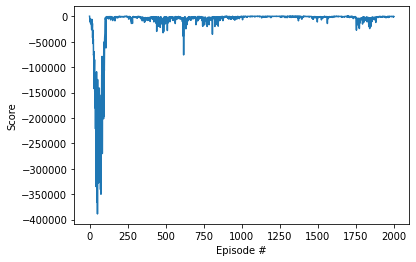

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
torch.save(agent.policy_network.state_dict(), "./trained_models/g1-forward/POLICY.pth")
torch.save(agent.value_network_target.state_dict(), "./trained_models/g1-forward/VALUE_TARGET.pth")
torch.save(agent.q_network_1.state_dict(), "./trained_models/g1-forward/Q_1.pth")
torch.save(agent.q_network_2.state_dict(), "./trained_models/g1-forward/Q_2.pth")

In [13]:
env.close()